In [74]:
####################read dataset#########################
import os
import random
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

image_folder = "data/img"
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(".jpg")]
#image_files

######################split dataset#######################
random.seed(0)
random.shuffle(image_files)
total_images = len(image_files)
train_ratio = 0.8

train_files = image_files[:int(total_images * train_ratio)]
test_files = image_files[int(total_images * train_ratio):]
#print(train_files)
#print(test_files)

In [75]:
#Create a vocabulary dictionary that maps all the unique color tokens from your train and test data as keys to a unique integer value.
item_attr_data = pd.read_csv("data/item_attr_data_cleaned.csv")
color_unique = item_attr_data['clothes_color'].unique()
print("number of colors:",len(color_unique))
color_vocab = sorted(set(color_unique))
color_vocabulary = {w:i for i, w in enumerate(color_vocab)}
#print(color_vocabulary)
for i,j in enumerate(item_attr_data['clothes_color']):
    color_value = color_vocabulary[j]
    item_attr_data.loc[i, "clothes_color"] = color_value

number of colors: 759


In [76]:
###################train dataset label##########################
train_ids=[]
for train_index in train_files:
    parts = train_index.split('/')
    train_ids.append(parts[2][:-4])
    
train_labels = pd.DataFrame(columns=item_attr_data.columns)
train_labels = pd.concat([item_attr_data[item_attr_data['img_idx']==i] for i in train_ids], axis=0, ignore_index=True)
train_labels = train_labels.drop(columns=['index','img_idx'])
train_color = train_labels.pop('clothes_color')

train_color_np = train_color.to_numpy(dtype=np.int32)
train_labels_np = train_labels.to_numpy(dtype=np.float32)
train_labels_np = (train_labels_np + 1) / 2

###################test dataset label##########################
test_ids=[]
for test_index in test_files:
    parts = test_index.split('/')
    test_ids.append(parts[2][:-4])
    
test_labels = pd.DataFrame(columns=item_attr_data.columns)
test_labels = pd.concat([item_attr_data[item_attr_data['img_idx']==i] for i in test_ids], axis=0, ignore_index=True)
test_labels = test_labels.drop(columns=['index','img_idx'])
test_color = test_labels.pop('clothes_color')

test_color_np = test_color.to_numpy(dtype=np.int32)
test_labels_np = test_labels.to_numpy(dtype=np.float32)
test_labels_np = (test_labels_np + 1) / 2

# print(train_labels_np[:5])
# print(train_color_np[:5])

In [77]:
def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (64, 64))
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [78]:
batch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(test_files)
test_dataset = test_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [79]:
train_color_ids_dataset = tf.data.Dataset.from_tensor_slices(train_color_np)
test_color_ids_dataset = tf.data.Dataset.from_tensor_slices(test_color_np)

train_binary_attributes_dataset = tf.data.Dataset.from_tensor_slices(train_labels_np)
test_binary_attributes_dataset = tf.data.Dataset.from_tensor_slices(test_labels_np)

train_dataset = tf.data.Dataset.zip((train_dataset, train_color_ids_dataset, train_binary_attributes_dataset))
test_dataset = tf.data.Dataset.zip((test_dataset, test_color_ids_dataset, test_binary_attributes_dataset))

train_dataset = train_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [80]:
print(test_dataset)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None), TensorSpec(shape=(None, 463), dtype=tf.float32, name=None))>


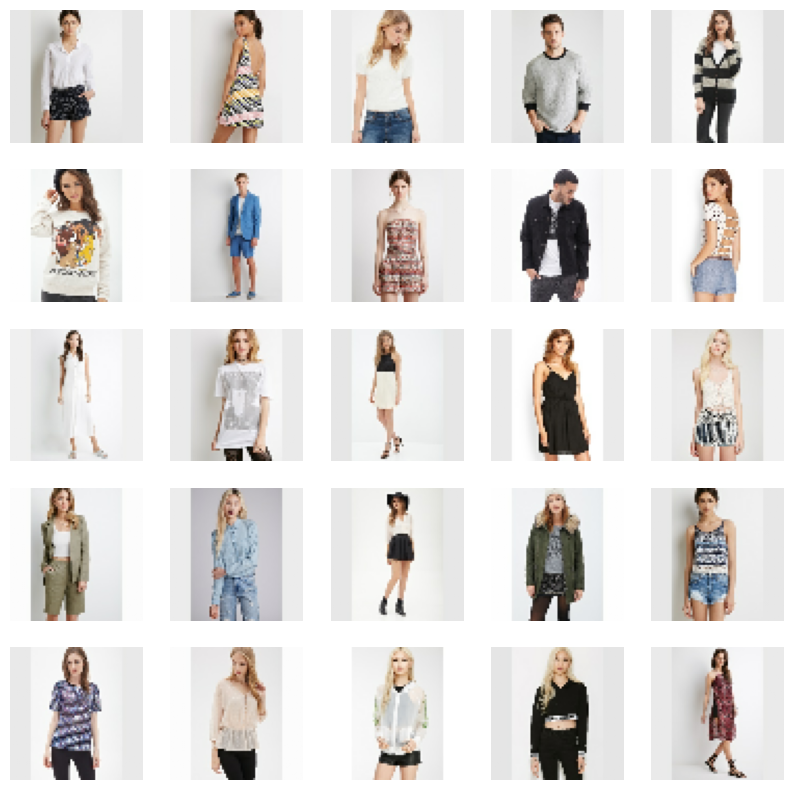

In [81]:
#################show the image####################
# Define a function to display a batch of images
def show_images(image_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.axis('off')
    plt.show()
    
# Get a batch of images from the train_dataset
for images, color_ids, binary_attributes in train_dataset.take(1):
    show_images(images)

In [89]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K

# Hyperparameters
embedding_dimension = 16
latent_dimension = 256
num_colors = 759
num_binary_attributes = 463
input_shape = (64, 64, 3)

# Cloth color embedding layer
color_embedding = layers.Embedding(num_colors, embedding_dimension, name="color_embedding")

# Encoder
# def create_encoder(input_shape, num_attributes):
#     inputs = Input(shape=input_shape, name="encoder_input")
#     attr_inputs = Input(shape=(num_attributes,), name="attribute_input")
    
#     x = layers.Conv2D(32, kernel_size=3, strides=2, padding="same", activation="relu")(inputs)
#     x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    
#     x = layers.Flatten()(x)
#     x = layers.Dense(latent_dimension, activation="relu")(x)
    
#     attr_x = layers.Dense(latent_dimension, activation="relu")(attr_inputs)
#     attr_x = layers.Dense(latent_dimension, activation="relu")(attr_x)
#     attr_x = layers.Dense(latent_dimension, activation="relu")(attr_x)
#     merged = layers.Concatenate()([x, attr_x])   
    
#     z_mean = layers.Dense(latent_dimension, name="z_mean")(merged)
#     z_log_var = layers.Dense(latent_dimension, name="z_log_var")(merged)
    
#     return Model([inputs, attr_inputs], [z_mean, z_log_var], name="encoder")

def create_vgg16_encoder(input_shape, num_attributes):
    inputs = Input(shape=input_shape, name="encoder_input")
    attr_inputs = Input(shape=(num_attributes,), name="attribute_input")
    
    # Use VGG16 as a feature extractor
    vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Set VGG16 layers to non-trainable
    for layer in vgg16.layers:
        layer.trainable = False
    
    # Apply VGG16 to the input images
    x = vgg16(inputs)
    
    # Flatten and reduce the dimensionality of the VGG16 features
    x = layers.Flatten()(x)
    x = layers.Dense(latent_dimension, activation="relu")(x)
    
    attr_x = layers.Dense(latent_dimension, activation="relu")(attr_inputs)
    attr_x = layers.Dense(latent_dimension, activation="relu")(attr_x)
    
    merged = layers.Concatenate()([x, attr_x])
    
    z_mean = layers.Dense(latent_dimension, name="z_mean")(merged)
    z_log_var = layers.Dense(latent_dimension, name="z_log_var")(merged)
    
    return Model([inputs, attr_inputs], [z_mean, z_log_var], name="encoder")

def create_unet_decoder(latent_dimension, num_attributes):
    inputs = Input(shape=(latent_dimension + num_attributes,), name="decoder_input")

    x = layers.Dense(64 * 64 * 64, activation="relu")(inputs)
    x = layers.Reshape((64, 64, 64))(x)

    # Encoder part (contracting path)
    e1 = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    e2 = layers.Conv2D(128, kernel_size=3, strides=2, padding="same", activation="relu")(e1)

    # Decoder part (expanding path)
    d1 = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same", activation="relu")(e2)
    d1 = layers.Concatenate()([d1, e1])  # Skip connection
    d2 = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu")(d1)
    d2 = layers.Concatenate()([d2, x])  # Skip connection

    outputs = layers.Conv2DTranspose(3, kernel_size=3, padding="same", activation="sigmoid", name="decoder_output")(d2)

    return Model(inputs, outputs, name="decoder")

# # Decoder
# def create_decoder(latent_dimension, num_attributes):
#     inputs = Input(shape=(latent_dimension + num_attributes,), name="decoder_input")
    
#     x = layers.Dense(latent_dimension, activation="relu")(inputs)
#     x = layers.Dense(16 * 16 * 16, activation="relu")(x)
#     x = layers.Reshape((16, 16, 16))(x)
    
#     x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
#     x = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    
#     outputs = layers.Conv2DTranspose(3, kernel_size=3, padding="same", activation="sigmoid", name="decoder_output")(x)
    
#     return Model(inputs, outputs, name="decoder")

# CVAE Model
class CVAE(Model):
    def __init__(self, encoder, decoder, color_embedding, num_binary_attributes, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.color_embedding = color_embedding
        self.num_binary_attributes = num_binary_attributes
    
    def call(self, inputs, training=False):
        images, color_ids, binary_attributes = inputs
        
        # Get color embeddings
        color_embeds = self.color_embedding(color_ids)
        
        # Concatenate color embeddings with binary attributes
        attribute_vector = layers.Concatenate(axis=-1)([color_embeds, binary_attributes])
        #attribute_vector = layers.Concatenate(axis=-1)([color_embeds])
        
        # Encode input images and attributes
        z_mean, z_log_var = self.encoder([images, attribute_vector])
        
        # Sample from the latent space
        batch_size = tf.shape(images)[0]
        epsilon = tf.random.normal(shape=(batch_size, latent_dimension))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        
        # Concatenate latent vector with the attribute vector
        z_cond = layers.Concatenate(axis=-1)([z, attribute_vector])
        
        # Decode the conditioned latent vector
        reconstructed_images = self.decoder(z_cond)
        
        return reconstructed_images, z_mean, z_log_var

# Instantiate the encoder, decoder, and CVAE model
#encoder = create_encoder(input_shape, embedding_dimension + num_binary_attributes)
# decoder = create_decoder(latent_dimension, embedding_dimension + num_binary_attributes)
# cvae = CVAE(encoder, decoder, color_embedding, num_binary_attributes)
vgg16_encoder = create_vgg16_encoder(input_shape, embedding_dimension + num_binary_attributes)
unet_decoder = create_unet_decoder(latent_dimension, embedding_dimension + num_binary_attributes)
cvae = CVAE(vgg16_encoder, unet_decoder, color_embedding, num_binary_attributes)
#cvae = CVAE(encoder, unet_decoder, color_embedding, num_binary_attributes)
# encoder = create_encoder(input_shape, embedding_dimension)
# decoder = create_decoder(latent_dimension, embedding_dimension)
# cvae = CVAE(encoder, decoder, color_embedding, num_binary_attributes)

# Loss function and optimizer
reconstruction_loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Custom training step
@tf.function
def train_step(images, color_ids, binary_attributes):
    beta = 0.1
    with tf.GradientTape() as tape:
        reconstructed_images, z_mean, z_log_var = cvae([images, color_ids, binary_attributes], training=True)
        
        # Calculate reconstruction loss
        rec_loss = reconstruction_loss(layers.Flatten()(images), layers.Flatten()(reconstructed_images))
        rec_loss *= input_shape[0] * input_shape[1] * input_shape[2]
        
        # Calculate KL divergence loss
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        kl_loss = tf.reduce_mean(kl_loss)
        
        # Combine losses
        total_loss = rec_loss + beta * kl_loss
    
    # Calculate gradients and update model weights
    gradients = tape.gradient(total_loss, cvae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, cvae.trainable_variables))
    
    return total_loss, rec_loss, kl_loss

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    for batch_images, batch_color_ids, batch_binary_attributes in train_dataset:
        total_loss, rec_loss, kl_loss = train_step(batch_images, batch_color_ids, batch_binary_attributes)
        print(f"Total loss: {total_loss:.4f}, Reconstruction loss: {rec_loss:.4f}, KL loss: {kl_loss:.4f}")

Epoch 1/10
Total loss: 1893.4263, Reconstruction loss: 1893.0149, KL loss: 41.1436
Total loss: 1907.8689, Reconstruction loss: 1907.4827, KL loss: 38.6265
Total loss: 1829.6407, Reconstruction loss: 1829.2310, KL loss: 40.9808
Total loss: 1782.8218, Reconstruction loss: 1782.3816, KL loss: 44.0203
Total loss: 1759.4164, Reconstruction loss: 1758.9338, KL loss: 48.2529
Total loss: 1695.3890, Reconstruction loss: 1694.8679, KL loss: 52.1086
Total loss: 1654.5159, Reconstruction loss: 1653.9470, KL loss: 56.8828
Total loss: 1564.8325, Reconstruction loss: 1564.2078, KL loss: 62.4753
Total loss: 1488.9773, Reconstruction loss: 1488.2993, KL loss: 67.8026
Total loss: 1426.3627, Reconstruction loss: 1425.6221, KL loss: 74.0554
Total loss: 1345.3107, Reconstruction loss: 1344.4888, KL loss: 82.1951
Total loss: 1258.0885, Reconstruction loss: 1257.1807, KL loss: 90.7854
Total loss: 1145.3123, Reconstruction loss: 1144.2928, KL loss: 101.9394
Total loss: 1043.4592, Reconstruction loss: 1042.319

Total loss: 429.4028, Reconstruction loss: 427.1298, KL loss: 227.3023
Total loss: 419.1445, Reconstruction loss: 416.8755, KL loss: 226.9005
Total loss: 438.7153, Reconstruction loss: 436.4401, KL loss: 227.5261
Total loss: 446.2751, Reconstruction loss: 443.9684, KL loss: 230.6699
Total loss: 414.4129, Reconstruction loss: 412.1454, KL loss: 226.7529
Total loss: 424.9257, Reconstruction loss: 422.6340, KL loss: 229.1750
Total loss: 433.6692, Reconstruction loss: 431.3617, KL loss: 230.7487
Total loss: 409.2297, Reconstruction loss: 407.0331, KL loss: 219.6652
Total loss: 396.8318, Reconstruction loss: 394.4932, KL loss: 233.8561
Total loss: 419.3499, Reconstruction loss: 417.0025, KL loss: 234.7457
Total loss: 452.9046, Reconstruction loss: 450.6281, KL loss: 227.6459
Total loss: 414.9608, Reconstruction loss: 412.6498, KL loss: 231.1032
Total loss: 465.8088, Reconstruction loss: 463.5770, KL loss: 223.1785
Epoch 3/10
Total loss: 393.6840, Reconstruction loss: 391.3998, KL loss: 228.

Total loss: 365.7744, Reconstruction loss: 363.9568, KL loss: 181.7562
Total loss: 338.0057, Reconstruction loss: 336.2027, KL loss: 180.3017
Total loss: 348.9137, Reconstruction loss: 347.1769, KL loss: 173.6859
Total loss: 365.0904, Reconstruction loss: 363.2940, KL loss: 179.6396
Total loss: 341.3088, Reconstruction loss: 339.5527, KL loss: 175.6028
Total loss: 362.1226, Reconstruction loss: 360.3351, KL loss: 178.7469
Total loss: 335.6576, Reconstruction loss: 333.8518, KL loss: 180.5781
Total loss: 370.9424, Reconstruction loss: 369.1380, KL loss: 180.4332
Total loss: 357.2964, Reconstruction loss: 355.5547, KL loss: 174.1702
Total loss: 358.7658, Reconstruction loss: 356.9957, KL loss: 177.0144
Total loss: 354.2604, Reconstruction loss: 352.5152, KL loss: 174.5257
Total loss: 331.6492, Reconstruction loss: 329.8672, KL loss: 178.1966
Total loss: 340.1794, Reconstruction loss: 338.4264, KL loss: 175.3013
Total loss: 339.6459, Reconstruction loss: 337.8963, KL loss: 174.9620
Total 

Total loss: 313.0212, Reconstruction loss: 310.6454, KL loss: 237.5736
Total loss: 277.9976, Reconstruction loss: 275.6082, KL loss: 238.9410
Total loss: 315.6367, Reconstruction loss: 313.2556, KL loss: 238.1133
Total loss: 293.8004, Reconstruction loss: 291.4401, KL loss: 236.0296
Total loss: 298.0443, Reconstruction loss: 295.6467, KL loss: 239.7648
Total loss: 290.7489, Reconstruction loss: 288.3749, KL loss: 237.4019
Total loss: 320.5177, Reconstruction loss: 318.1356, KL loss: 238.2097
Total loss: 288.1125, Reconstruction loss: 285.6924, KL loss: 242.0126
Total loss: 296.5374, Reconstruction loss: 294.1240, KL loss: 241.3361
Total loss: 292.6925, Reconstruction loss: 290.2699, KL loss: 242.2669
Total loss: 285.5336, Reconstruction loss: 283.1097, KL loss: 242.3901
Total loss: 281.4958, Reconstruction loss: 279.0966, KL loss: 239.9104
Total loss: 291.6665, Reconstruction loss: 289.1963, KL loss: 247.0194
Total loss: 277.0654, Reconstruction loss: 274.5878, KL loss: 247.7598
Total 

Total loss: 265.9663, Reconstruction loss: 262.9546, KL loss: 301.1707
Total loss: 249.8793, Reconstruction loss: 246.8492, KL loss: 303.0099
Total loss: 260.2458, Reconstruction loss: 257.2125, KL loss: 303.3327
Total loss: 280.1478, Reconstruction loss: 277.1157, KL loss: 303.2177
Total loss: 255.4048, Reconstruction loss: 252.4351, KL loss: 296.9708
Total loss: 281.9036, Reconstruction loss: 278.8746, KL loss: 302.8928
Total loss: 268.9704, Reconstruction loss: 265.8996, KL loss: 307.0856
Total loss: 269.3868, Reconstruction loss: 266.4383, KL loss: 294.8503
Total loss: 250.3186, Reconstruction loss: 247.2545, KL loss: 306.4077
Total loss: 252.2134, Reconstruction loss: 249.1450, KL loss: 306.8448
Total loss: 260.1656, Reconstruction loss: 257.0634, KL loss: 310.2233
Total loss: 266.9849, Reconstruction loss: 263.9300, KL loss: 305.4924
Total loss: 279.1263, Reconstruction loss: 276.0502, KL loss: 307.6030
Total loss: 246.9596, Reconstruction loss: 243.8708, KL loss: 308.8759
Total 

Total loss: 241.3395, Reconstruction loss: 237.7137, KL loss: 362.5795
Total loss: 245.3317, Reconstruction loss: 241.7271, KL loss: 360.4619
Total loss: 241.1930, Reconstruction loss: 237.5631, KL loss: 362.9818
Total loss: 236.1276, Reconstruction loss: 232.5237, KL loss: 360.3931
Total loss: 234.2077, Reconstruction loss: 230.5837, KL loss: 362.4034
Total loss: 233.4183, Reconstruction loss: 229.7795, KL loss: 363.8854
Total loss: 237.1084, Reconstruction loss: 233.4596, KL loss: 364.8782
Total loss: 243.0403, Reconstruction loss: 239.3724, KL loss: 366.7923
Total loss: 248.0164, Reconstruction loss: 244.3479, KL loss: 366.8521
Total loss: 250.8580, Reconstruction loss: 247.1582, KL loss: 369.9818
Total loss: 243.7338, Reconstruction loss: 240.0351, KL loss: 369.8698
Total loss: 245.1282, Reconstruction loss: 241.4559, KL loss: 367.2309
Total loss: 238.7542, Reconstruction loss: 235.0390, KL loss: 371.5250
Total loss: 228.2807, Reconstruction loss: 224.5502, KL loss: 373.0554
Total 

In [90]:
# Evaluate the trained model on the test dataset
test_loss = []
for batch_images, batch_color_ids, batch_binary_attributes in test_dataset:
    reconstructed_images, z_mean, z_log_var = cvae([batch_images, batch_color_ids, batch_binary_attributes])
    rec_loss = reconstruction_loss(batch_images, reconstructed_images)
    rec_loss = tf.reduce_mean(rec_loss)
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    kl_loss = tf.reduce_mean(kl_loss)
    total_loss = rec_loss + kl_loss
    test_loss.append(total_loss)

test_loss = tf.reduce_mean(test_loss)
print(f"Test loss: {test_loss:.4f}")

Test loss: 396.6946


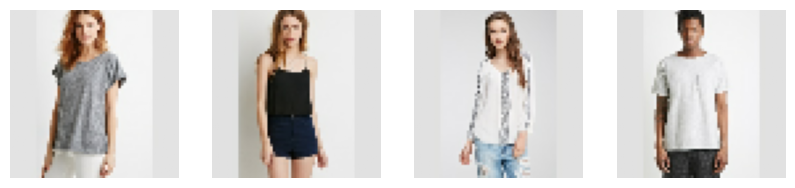

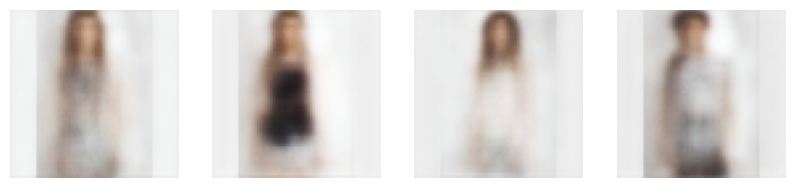

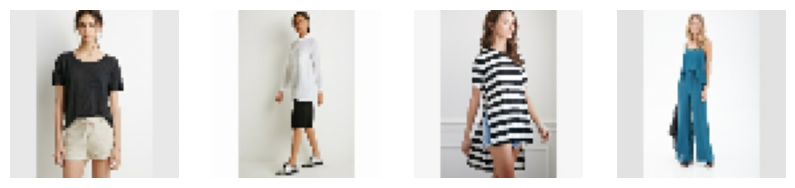

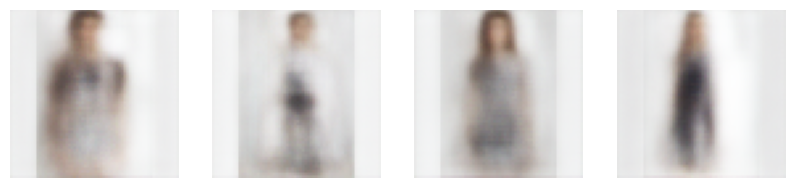

In [91]:
import matplotlib.pyplot as plt

def show(image_batch):
    plt.figure(figsize=(10,10))
    for n in range(4):
        ax = plt.subplot(1,4,n+1)
        plt.imshow(image_batch[n])
        plt.axis('off')
    plt.show()

for batch_images, batch_color_ids, batch_binary_attributes in test_dataset.take(2):
    reconstructed_images, _, _ = cvae([batch_images, batch_color_ids, batch_binary_attributes])
    show(batch_images)
    show(reconstructed_images)

In [92]:
def regenerate_image(image, new_color_id, new_binary_attributes):
    image = tf.expand_dims(image, axis=0)
    new_color_id = tf.expand_dims(new_color_id, axis=0)
    new_binary_attributes = tf.expand_dims(new_binary_attributes, axis=0)

    # Get color embeddings
    color_embeds = cvae.color_embedding(new_color_id)

    # Concatenate color embeddings with binary attributes
    attribute_vector = layers.Concatenate(axis=-1)([color_embeds, new_binary_attributes])

    # Encode input image and attributes
    z_mean, z_log_var = cvae.encoder([image, attribute_vector])

    # Sample from the latent space
    batch_size = tf.shape(image)[0]
    epsilon = tf.random.normal(shape=(batch_size, latent_dimension))
    z = z_mean + tf.exp(0.5 * z_log_var) * epsilon

    # Concatenate latent vector with the attribute vector
    z_cond = layers.Concatenate(axis=-1)([z, attribute_vector])

    # Decode the conditioned latent vector
    regenerated_image = cvae.decoder(z_cond)

    return regenerated_image[0]

Green-blue 


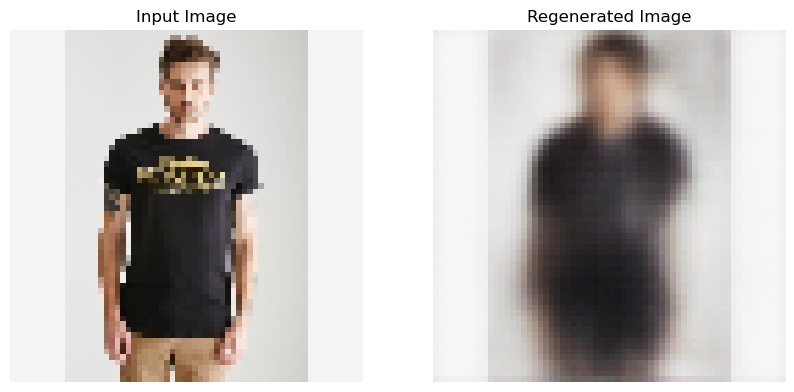

In [148]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

file = "data/img/id_00006158.jpg"
# Load the input image and preprocess it
input_image = cv2.imread(file)
input_image = cv2.resize(input_image, (64, 64))
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
input_image = input_image / 255.0

# Define new color ID and binary attributes
new_color_id = 299  # Any integer value between 0 and 758 (num_colors - 1)
print(list(color_vocabulary.keys())[list(color_vocabulary.values()).index(new_color_id)])
#new_binary_attributes = np.random.randint(0, 2, size=(num_binary_attributes,)).astype(np.float32)
binary_attributes = item_attr_data[item_attr_data['img_idx']==file[9:-4]]
binary_attributes = binary_attributes.drop(columns=['index','img_idx','clothes_color'])

new_binary_attributes = binary_attributes.to_numpy(dtype=np.float32).flatten()
new_binary_attributes = (new_binary_attributes + 1) / 2


# Generate the new image
regenerated_image = regenerate_image(input_image, new_color_id, new_binary_attributes)

# Plot the input and regenerated images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(input_image)
ax1.set_title("Input Image")
ax1.axis("off")

ax2.imshow(regenerated_image)
ax2.set_title("Regenerated Image")
ax2.axis("off")

plt.show()